In [56]:
from config import api_key, neptune_key
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers.recurrent import LSTM
from keras.layers import Input
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils


In [24]:
import neptune.new as neptune

run = neptune.init(
    project="derekhuggens/Stock-Project",
    api_token=neptune_key,
)  # your credentials

params = {"learning_rate": 0.001, "optimizer": "Adam"}
run["parameters"] = params

for epoch in range(10):
    run["train/loss"].log(0.9 ** epoch)

run["eval/f1_score"] = 0.66

run.stop()

https://app.neptune.ai/derekhuggens/Stock-Project/e/STOC-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.


All 27 operations synced, thanks for waiting!


In [105]:
run.stop()

In [40]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=api_key'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2022-04-08', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2022-04-08': {'1. open': '171.7800', '2. high': '171.7800', '3. low': '169.2000', '4. close': '170.0900', '5. volume': '76575508'}, '2022-04-07': {'1. open': '171.1600', '2. high': '173.3600', '3. low': '169.8500', '4. close': '172.1400', '5. volume': '77594650'}, '2022-04-06': {'1. open': '172.3600', '2. high': '173.6300', '3. low': '170.1300', '4. close': '171.8300', '5. volume': '89058782'}, '2022-04-05': {'1. open': '177.5000', '2. high': '178.3000', '3. low': '174.4150', '4. close': '175.0600', '5. volume': '70902999'}, '2022-04-04': {'1. open': '174.5700', '2. high': '178.4900', '3. low': '174.4400', '4. close': '178.4400', '5. volume': '76545983'}, '2022-04-01': {'1. open': '174.0300', '2. high': '174.8800', '3. low': '171.9400', '4. close': '174.3100', 

In [68]:
aapl_df_json = pd.DataFrame.from_dict(data, orient='index')
aapl_df_json

1. Information  \
Meta Data            Daily Prices (open, high, low, close) and Volumes   
Time Series (Daily)                                                NaN   

                    2. Symbol 3. Last Refreshed 4. Output Size 5. Time Zone  \
Meta Data                AAPL        2022-04-08      Full size   US/Eastern   
Time Series (Daily)       NaN               NaN            NaN          NaN   

                                                            2022-04-08  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '171.7800', '2. high': '171.7800',...   

                                                            2022-04-07  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '171.1600', '2. high': '173.3600',...   

                                                            2022-04-06  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '172.3600', '2. high': '173.6300',...   

                                                            2022-04-05  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '177.5000', '2. high': '178.3000',...   

                                                            2022-04-04  ...  \
Meta Data                                                          NaN  ...   
Time Series (Daily)  {'1. open': '174.5700', '2. high': '178.4900',...  ...   

                                                            1999-11-12  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '91.9400', '2. high': '92.0000', '...   

                                                            1999-11-11  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '91.5900', '2. high': '92.6200', '...   

                                                            1999-11-10  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '88.2500', '2. high': '93.2500', '...   

                                                            1999-11-09  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '94.3700', '2. high': '94.5000', '...   

                                                            1999-11-08  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '87.7500', '2. high': '97.7300', '...   

                                                            1999-11-05  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '84.6200', '2. high': '88.3700', '...   

                                                            1999-11-04  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '82.0600', '2. high': '85.3700', '...   

                                                            1999-11-03  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '81.6200', '2. high': '83.2500', '...   

                                                            1999-11-02  \
Meta Data                                                          NaN   
Time Series (Daily)  {'1. open': '78.0000', '2. high': '81.6900', '...   

                                                            1999-11-01  
Meta Data                                                          NaN  
Time Series (Daily)  {'1. open': '80.0000', '2. high': '80.6900', '...  

[2 rows x 5652 columns]

In [3]:
aapl_csv = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=api_key&datatype=csv'
aapl_csv_df = pd.read_csv(aapl_csv)  
print(aapl_csv_df)

       timestamp    open    high      low   close    volume
0     2022-04-08  171.78  171.78  169.200  170.09  76575508
1     2022-04-07  171.16  173.36  169.850  172.14  77594650
2     2022-04-06  172.36  173.63  170.130  171.83  89058782
3     2022-04-05  177.50  178.30  174.415  175.06  70902999
4     2022-04-04  174.57  178.49  174.440  178.44  76545983
...          ...     ...     ...      ...     ...       ...
5642  1999-11-05   84.62   88.37   84.000   88.31   3721500
5643  1999-11-04   82.06   85.37   80.620   83.62   3384700
5644  1999-11-03   81.62   83.25   81.000   81.50   2932700
5645  1999-11-02   78.00   81.69   77.310   80.25   3564600
5646  1999-11-01   80.00   80.69   77.370   77.62   2487300

[5647 rows x 6 columns]


In [4]:
len(aapl_csv_df.close)

5647

In [5]:
df_copy = aapl_csv_df.copy()

In [6]:
date_close_df = df_copy.filter(['timestamp','close'], axis=1)
date_close_df

timestamp   close
0     2022-04-08  170.09
1     2022-04-07  172.14
2     2022-04-06  171.83
3     2022-04-05  175.06
4     2022-04-04  178.44
...          ...     ...
5642  1999-11-05   88.31
5643  1999-11-04   83.62
5644  1999-11-03   81.50
5645  1999-11-02   80.25
5646  1999-11-01   77.62

[5647 rows x 2 columns]

In [7]:
date_close_df.tail(5)

timestamp  close
5642  1999-11-05  88.31
5643  1999-11-04  83.62
5644  1999-11-03  81.50
5645  1999-11-02  80.25
5646  1999-11-01  77.62

In [8]:
stockprices = date_close_df

In [9]:
#### Train-Test split for time-series ####
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print("train_size: " + str(train_size))
print("test_size: " + str(test_size))

train = stockprices[:train_size][['timestamp', 'close']]
test = stockprices[train_size:][['timestamp', 'close']]

train_size: 4517
test_size: 1129


In [13]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset 
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

In [14]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [18]:
def calculate_perf_metrics(var, logNeptune=True, logmodelName='Simple MA'):
    ### RMSE 
    rmse = calculate_rmse(np.array(stockprices[train_size:]['close']), np.array(stockprices[train_size:][var]))
    ### MAPE 
    mape = calculate_mape(np.array(stockprices[train_size:]['close']), np.array(stockprices[train_size:][var]))
    
    ## Log images to Neptune new version 
    if logNeptune:        
        npt_exp['RMSE'].log(rmse)
        npt_exp['MAPE (%)'].log(mape)
    
    return rmse, mape

In [20]:
def plot_stock_trend(var, cur_title, stockprices=stockprices, logNeptune=True, logmodelName='Simple MA'):
    ax = stockprices[['close', var,'200day']].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')

    ## Log images to Neptune new version 
    if logNeptune:
        npt_exp[f'Plot of Stock Predictions with {logmodelName}'].upload(neptune.types.File.as_image(ax.get_figure()))

https://app.neptune.ai/derekhuggens/Stock-Project/e/STOC-5
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.


All 17 operations synced, thanks for waiting!


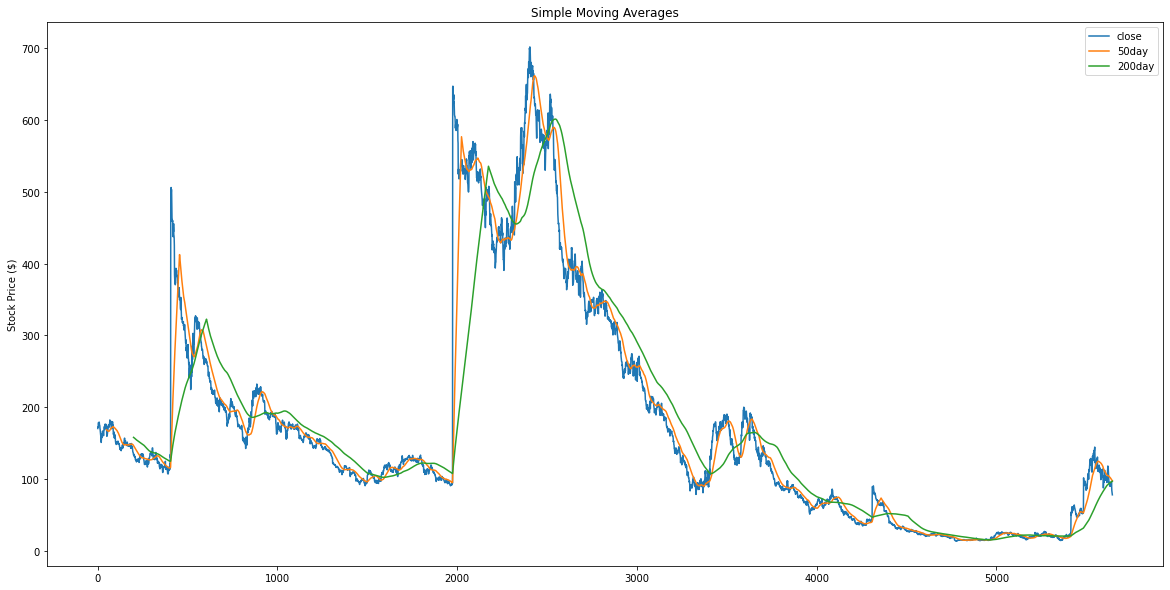

In [21]:
window_size = 50

import neptune.new as neptune

# Create an experiment and log the model in Neptune new version
npt_exp = neptune.init(    
        api_token=neptune_key,
        project="derekhuggens/Stock-Project", 
        name='SMA', 
        description='stock-prediction-machine-learning', 
        tags=['stockprediction', 'MA_Simple', 'neptune'])

window_var = str(window_size) + 'day'
    
stockprices[window_var] = stockprices['close'].rolling(window_size).mean()
### Include a 200-day SMA for reference 
stockprices['200day'] = stockprices['close'].rolling(200).mean()
    
### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title='Simple Moving Averages', logmodelName='Simple MA')
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var, logmodelName='Simple MA')

### Stop the run after logging for new version
npt_exp.stop()

https://app.neptune.ai/derekhuggens/Stock-Project/e/STOC-6
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.


All 17 operations synced, thanks for waiting!


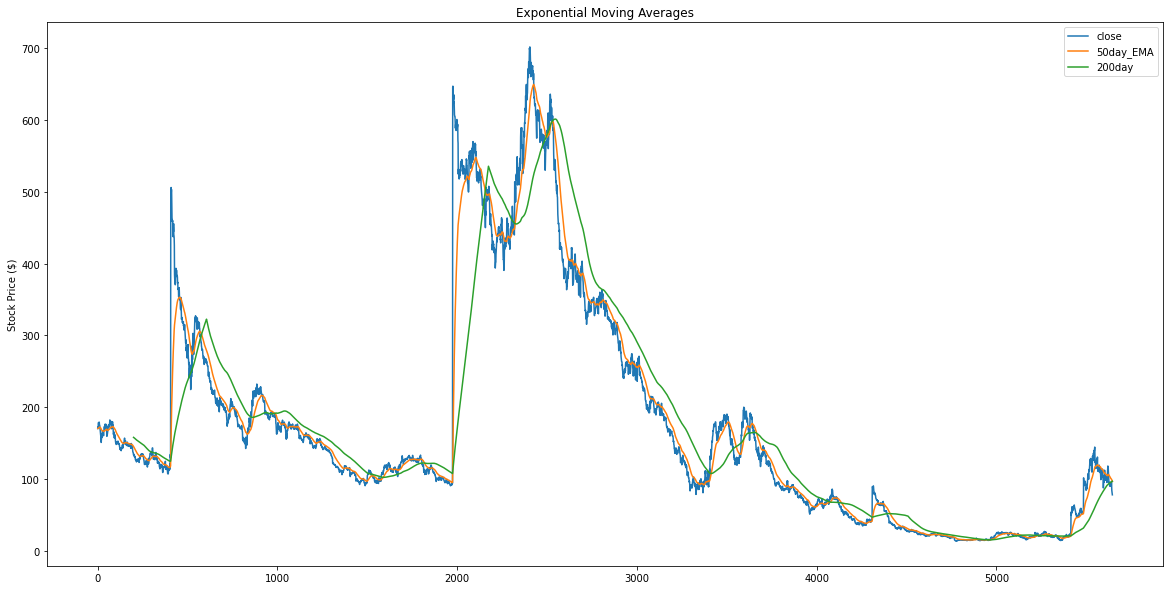

In [28]:
# Create an experiment and log the model in Neptune new version
npt_exp = neptune.init(    
        api_token=neptune_key,
        project="derekhuggens/Stock-Project", 
        name='EMA', 
        description='stock-prediction-machine-learning', 
        tags=['stockprediction', 'MA_Exponential', 'neptune'])      
    
###### Exponential MA
window_ema_var = window_var+'_EMA'
# Calculate the 50-day exponentially weighted moving average
stockprices[window_ema_var] = stockprices['close'].ewm(span=window_size, adjust=False).mean()
#stockprices[window_ema_var] = stockprices['close'].mean()
stockprices['200day'] = stockprices['close'].rolling(200).mean()
    
### Plot and performance metrics for EMA model
plot_stock_trend(var=window_ema_var, cur_title='Exponential Moving Averages', logmodelName='Exp MA')
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var, logmodelName='Exp MA')
### Stop the run after logging for new version
npt_exp.stop()

In [31]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 15
cur_batch_size = 20
    
cur_LSTM_pars = {'units': layer_units, 
                 'optimizer': optimizer, 
                 'batch_size': cur_batch_size, 
                 'epochs': cur_epochs
                 }
    
# Create an experiment and log the model in Neptune new version
npt_exp = neptune.init(    
        api_token=neptune_key,
        project="derekhuggens/Stock-Project", 
        name='LSTM',         
        description='stock-prediction-machine-learning', 
        tags=['stockprediction', 'LSTM','neptune'])   
npt_exp['LSTMPars'] = cur_LSTM_pars

https://app.neptune.ai/derekhuggens/Stock-Project/e/STOC-7
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [36]:
# scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['close']])
scaled_data_train = scaled_data[:train.shape[0]]
    
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

In [50]:
### Build a LSTM model and log model summary to Neptune ###    
def Run_LSTM(X_train, layer_units=50, logNeptune=True, NeptuneProject=None):     
    inp = Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = keras.Model(inp, out)
    
    # Compile the LSTM neural net
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    ## !!! log to Neptune, e.g., set NeptuneProject = npt_exp (new version)
    if logNeptune:
       model.summary(print_fn=lambda x: NeptuneProject['model_summary'].log(x))
        
    return model   

model = Run_LSTM(X_train, layer_units=layer_units, logNeptune=True, NeptuneProject=npt_exp)

history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/15
201/201 [==============================] - 8s 31ms/step - loss: 0.0495 - val_loss: 0.0028
Epoch 2/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0176 - val_loss: 9.6163e-04
Epoch 3/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 4/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0117 - val_loss: 9.2867e-04
Epoch 5/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0102 - val_loss: 0.0014
Epoch 6/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0090 - val_loss: 6.6786e-04
Epoch 7/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0083 - val_loss: 7.2423e-04
Epoch 8/15
201/201 [==============================] - 6s 30ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 9/15
201/201 [==============================] - 6s 32ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 10/15
201/201 [==============================] - 6s 31ms/step - loss:

In [52]:
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):    
    raw = data['close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)
    
    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price 
test['Predictions_lstm'] = predicted_price

C:\Users\derek\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.


All 2 operations synced, thanks for waiting!


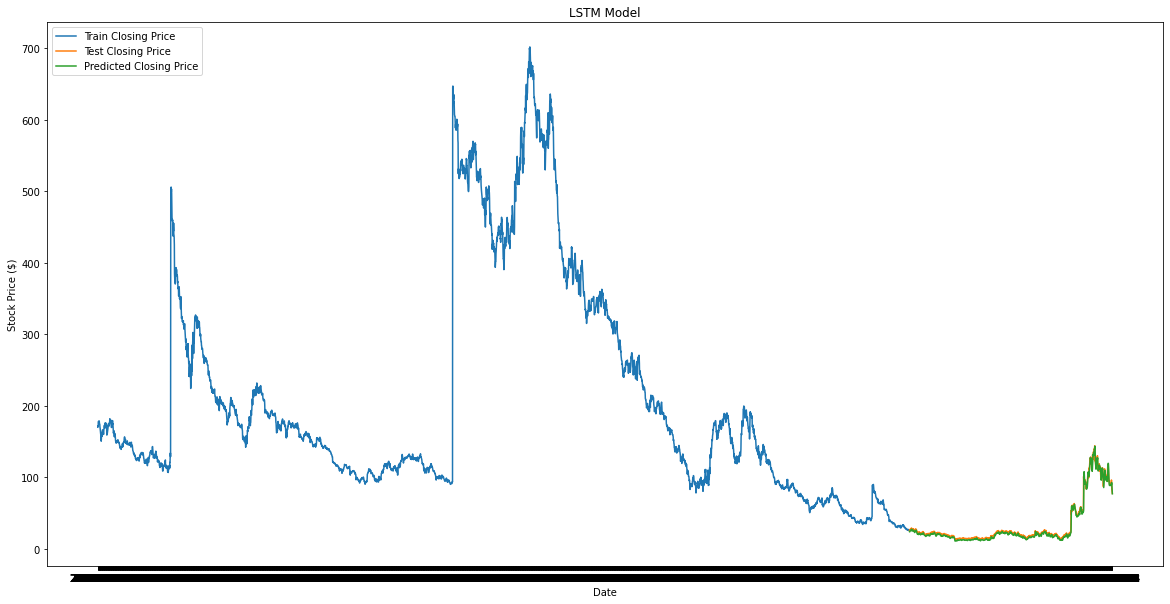

In [55]:
# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test['close']), np.array(test['Predictions_lstm']))
mape_lstm = calculate_mape(np.array(test['close']), np.array(test['Predictions_lstm']))

### Neptune new version
npt_exp['RMSE'].log(rmse_lstm)
npt_exp['MAPE (%)'].log(mape_lstm)

### Plot prediction and true trends and log to Neptune         
def plot_stock_trend_lstm(train, test, logNeptune=True):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['timestamp'], train['close'], label = 'Train Closing Price')
    plt.plot(test['timestamp'], test['close'], label = 'Test Closing Price')
    plt.plot(test['timestamp'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")
    
## Log image to Neptune new version
    if logNeptune:
        npt_exp['Plot of Stock Predictions with LSTM'].upload(neptune.types.File.as_image(fig))  
        
plot_stock_trend_lstm(train, test)

### Stop the run after logging for new version 
npt_exp.stop()